In [63]:
# LIBRARIES
# Import necessary libraries
import sys
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from CustomModel import EinarPersistorModelType1L
from CustomModel import EinarPersistorModelType2L
from CustomModel import EinarPersistorModelType3L
from CustomModel import EinarPersistorModelTypeU

In [64]:
# COPIED FUNCTIONALITY CODE
outDir = "./data/sensitiveResistantModel/"
solver_kws={'method':'LSODA', # this chooses the ODE solver. Options are those available in scipy.integrate.odeint. DOP853 is a good go-to.
            'absErr':1.0e-8, 'relErr':1.0e-6, # absolute and relative error tolerances
            'suppressOutputB':False # suppresses the output of the solver. This is useful for long simulations where you don't want to see the output.
            }

In [65]:
# MODEL TYPE: 1L
einar_model = EinarPersistorModelType1L()
d = einar_model.paramDic
d

{'DMax': 100,
 'CASE': 'Linear 1',
 'n': 1500,
 'fracRes': 0.01,
 'Cmax': 10,
 'k': 0.0004,
 'm': 0.0004,
 'u0': 0.0004,
 'v0': 0.004,
 'lambda0': 0.04,
 'lambda1': 0.001,
 'delta_d0': 0.08}

In [66]:
# OPTIMAL TREATMENT UNDER CONSTANT DOSE: 1L
lst = []
for a in np.arange(0, 10.01, 0.01):
    lambda_c = d['lambda0'] - d['delta_d0'] * (a / (a + 1))
    u_c = d['u0'] + d['k'] * a
    v_c = d['v0']
    sigma_c = 0.5*(lambda_c - u_c + d['lambda1'] - v_c + (((lambda_c - u_c - d['lambda1'] + v_c)**2) + (4 * u_c * v_c)) ** 0.5)
    lst.append(sigma_c)
sigma_min = min(lst)
print('Minimized Tumor Growth Rate: ', sigma_min)
c_opt = lst.index(sigma_min)*0.01
print('Optimal Dose (0 - 10): ', c_opt)
print('Optimal cfrac: ', c_opt/10)

Minimized Tumor Growth Rate:  -0.0026636016338251
Optimal Dose (0 - 10):  3.29
Optimal cfrac:  0.329


In [67]:
# TYPE 1L SIMULATION: SCHEDULING
einar_model.initialStateList = [d['n']*(1-d['fracRes']), d['n']*d['fracRes']] # Starter values
example_schedule = [[0, 7*24, 0.329]]
einar_model.Simulate(example_schedule, solver_kws=solver_kws)

In [68]:
# CUSTOM TRIM
# Saves time
einar_model.Trim(dt=1)

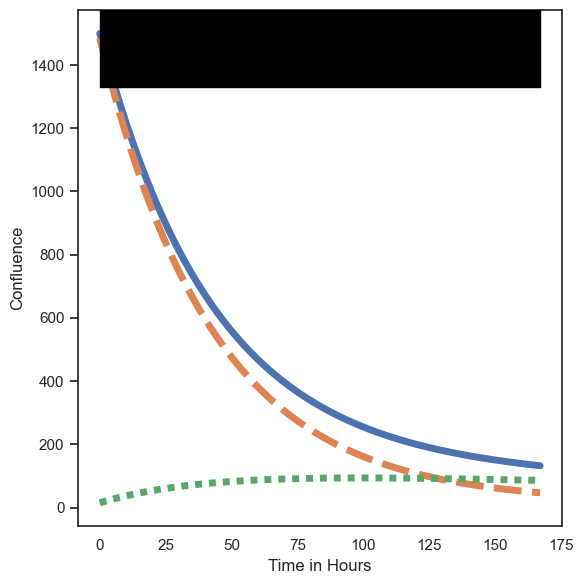

In [69]:
# PLOT
fix, ax = plt.subplots(1,1,figsize=(6,6))
einar_model.Plot(ax=ax)

In [70]:
# MODEL TYPE: 2L
einar_model = EinarPersistorModelType2L()
d = einar_model.paramDic
d

{'DMax': 100,
 'CASE': 'Linear 2',
 'n': 1500,
 'fracRes': 0.01,
 'Cmax': 10,
 'k': 0.0004,
 'm': 0.0004,
 'u0': 0.0004,
 'v0': 0.004,
 'lambda0': 0.04,
 'lambda1': 0.001,
 'delta_d0': 0.08}

In [71]:
# OPTIMAL TREATMENT UNDER CONSTANT DOSE: 2L
lst = []
for a in np.arange(0, 10.01, 0.01):
    lambda_c = d['lambda0'] - d['delta_d0'] * (a / (a + 1))
    u_c = d['u0']
    v_c = d['v0'] - d['m'] * a
    sigma_c = 0.5*(lambda_c - u_c + d['lambda1'] - v_c + (((lambda_c - u_c - d['lambda1'] + v_c)**2) + (4 * u_c * v_c)) ** 0.5)
    lst.append(sigma_c)
sigma_min = min(lst)
print('Minimized Tumor Growth Rate: ', sigma_min)
c_opt = lst.index(sigma_min)*0.01
print('Optimal Dose (0 - 10): ', c_opt)
print('Optimal cfrac: ', c_opt/10)

Minimized Tumor Growth Rate:  -0.0021826111622773392
Optimal Dose (0 - 10):  1.54
Optimal cfrac:  0.154


In [72]:
# TYPE 2L SIMULATION: SCHEDULING
einar_model.initialStateList = [d['n']*(1-d['fracRes']), d['n']*d['fracRes']] # Starter values
example_schedule = [[0, 100*24, 0.154]]
einar_model.Simulate(example_schedule, solver_kws=solver_kws)

In [73]:
# CUSTOM TRIM
# Saves time
einar_model.Trim(dt=1)

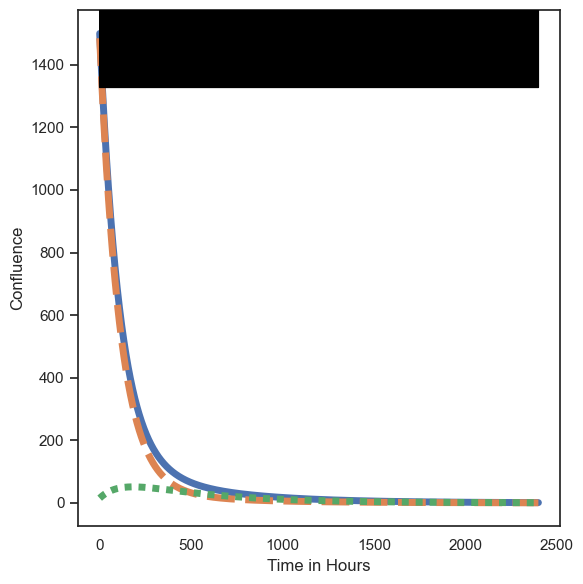

In [74]:
# PLOT
fix, ax = plt.subplots(1,1,figsize=(6,6)) 
einar_model.Plot(ax=ax) 

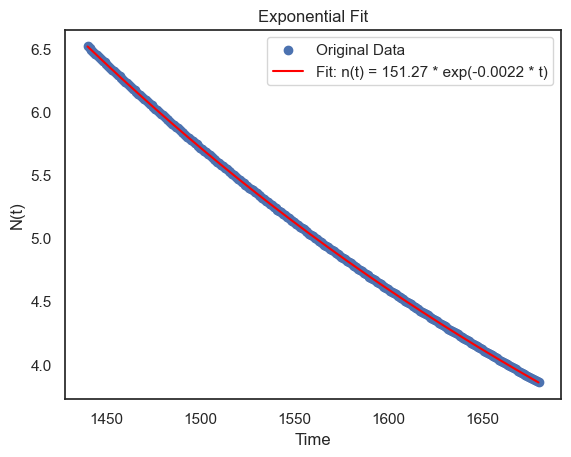

Estimated parameters: n0 = 151.27, a = -0.00218404
Fitted function: N(t) = 151.27 * exp(-0.0022 * t)


In [75]:
# TESTING LONG TERM RATE VALUE

# Data Extraction
# Choose a time very far into the simulation (20+ days) in order to ensure that an equilibrium position has been reacher
start_hr = 60*24 # Make sure the start and end hour are present within the trimmed data
end_hr = 70*24
filtered_df = einar_model.resultsDf[(einar_model.resultsDf["Time"] >= start_hr) & (einar_model.resultsDf["Time"] <= end_hr)]
x_data = filtered_df["Time"].values
y_data = filtered_df["TumourSize"].values

# Fit Function Code
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy.optimize import curve_fit

def expFunc(t, n0, a):
    return n0 * np.exp(np.clip(a * t, -700, 700))

params, _ = curve_fit(expFunc, x_data, y_data, p0=[3000, -0.005])
n0_fit, a_fit = params

y_fit = expFunc(x_data, n0_fit, a_fit)

# Plotted Results Code
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, y_fit, color='red', label=f'Fit: n(t) = {n0_fit:.2f} * exp({a_fit:.4f} * t)')
plt.legend()
plt.xlabel("Time")
plt.ylabel("N(t)")
plt.title("Exponential Fit")
plt.show()

# Note that (a) should be essentially equal to the minimized tumor growth rate
print(f"Estimated parameters: n0 = {n0_fit:.2f}, a = {a_fit:.8f}")
print(f"Fitted function: N(t) = {n0_fit:.2f} * exp({a_fit:.4f} * t)")

In [76]:
# MODEL TYPE: 3L
einar_model = EinarPersistorModelType3L()
d = einar_model.paramDic
d

{'DMax': 100,
 'CASE': 'Linear 3',
 'n': 1500,
 'fracRes': 0.01,
 'Cmax': 10,
 'k': 0.0004,
 'm': 0.0004,
 'u0': 0.0004,
 'v0': 0.004,
 'lambda0': 0.04,
 'lambda1': 0.001,
 'delta_d0': 0.08}

In [77]:
# OPTIMAL TREATMENT UNDER CONSTANT DOSE: 3L
lst = []
for a in np.arange(0, 10.01, 0.01):
    lambda_c = d['lambda0'] - d['delta_d0'] * (a / (a + 1))
    u_c = d['u0'] + d['k'] * a
    v_c = d['v0'] - d['m'] * a
    sigma_c = 0.5*(lambda_c - u_c + d['lambda1'] - v_c + (((lambda_c - u_c - d['lambda1'] + v_c)**2) + (4 * u_c * v_c)) ** 0.5)
    lst.append(sigma_c)
sigma_min = min(lst)
print('Minimized Tumor Growth Rate: ', sigma_min)
c_opt = lst.index(sigma_min)*0.01
print('Optimal Dose (0 - 10): ', c_opt)
print('Optimal cfrac: ', c_opt/10)

Minimized Tumor Growth Rate:  -0.0019435882491719986
Optimal Dose (0 - 10):  1.67
Optimal cfrac:  0.16699999999999998


In [78]:
# TYPE 3L SIMULATION: SCHEDULING
einar_model.initialStateList = [d['n']*(1-d['fracRes']), d['n']*d['fracRes']] # Starter values
example_schedule = [[0, 2*24, 0], [2*24, 20*24, 1]]
einar_model.Simulate(example_schedule, solver_kws=solver_kws)

In [79]:
# CUSTOM TRIM
# Saves time
einar_model.Trim(dt=1)

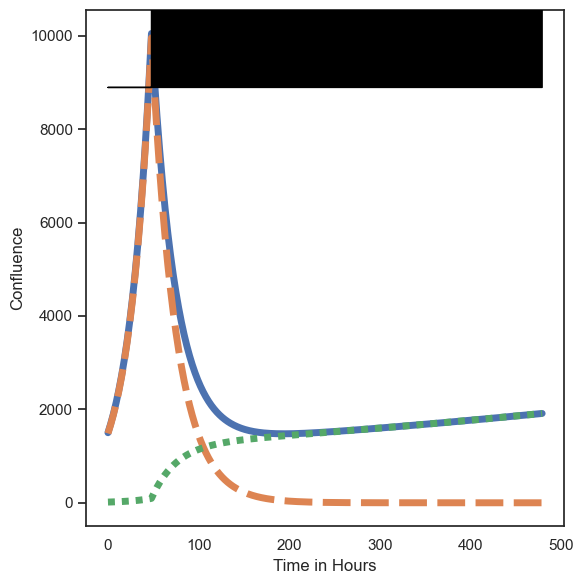

In [80]:
# PLOT
fix, ax = plt.subplots(1,1,figsize=(6,6)) 
einar_model.Plot(ax=ax)

In [81]:
# MODEL TYPE: U
einar_model = EinarPersistorModelTypeU()
d = einar_model.paramDic
d

{'DMax': 100,
 'CASE': 'Uniform',
 'n': 1500,
 'fracRes': 0.01,
 'Cmax': 10,
 'u0': 0.0004,
 'v0': 0.004,
 'lambda0': 0.04,
 'lambda1': 0.001,
 'delta_d0': 0.08,
 'delta_u': 0.004,
 'delta_v': 0.003}

In [82]:
# OPTIMAL TREATMENT UNDER CONSTANT DOSE: U
lst = []
for a in np.arange(0.01, 10.01, 0.01):
    lambda_c = d['lambda0'] - d['delta_d0'] * (a / (a + 1))
    u_c = d['u0'] + d['delta_u']
    v_c = d['v0'] - d['delta_v']
    sigma_c = 0.5*(lambda_c - u_c + d['lambda1'] - v_c + (((lambda_c - u_c - d['lambda1'] + v_c)**2) + (4 * u_c * v_c)) ** 0.5)
    lst.append(sigma_c)
sigma_min = min(lst)
print('Minimized Tumor Growth Rate: ', sigma_min)
c_opt = (lst.index(sigma_min)*0.01) + 0.01
print('Optimal Dose (0 - 10): ', c_opt)
print('Optimal cfrac: ', c_opt/10)

Minimized Tumor Growth Rate:  0.00011813536822360624
Optimal Dose (0 - 10):  10.0
Optimal cfrac:  1.0


In [83]:
# TYPE U SIMULATION: SCHEDULING
einar_model.initialStateList = [d['n']*(1-d['fracRes']), d['n']*d['fracRes']] # Starter values
example_schedule = [[0, 100*24, 1]]
einar_model.Simulate(example_schedule, solver_kws=solver_kws)

In [84]:
# CUSTOM TRIM
# Saves time
einar_model.Trim(dt=1)

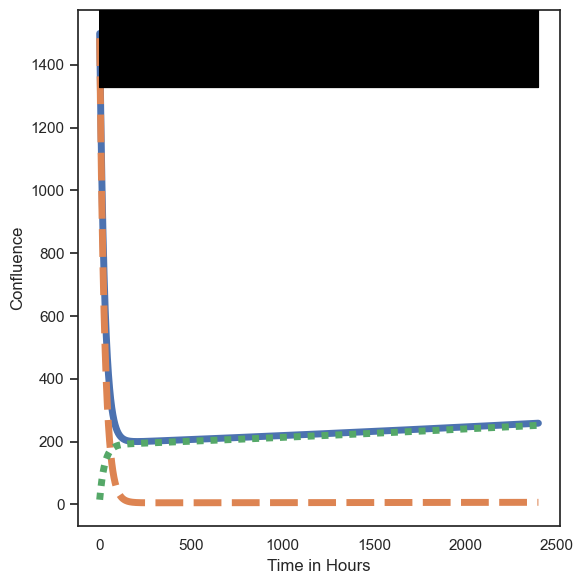

In [85]:
# PLOT
fix, ax = plt.subplots(1,1,figsize=(6,6)) 
einar_model.Plot(ax=ax) 

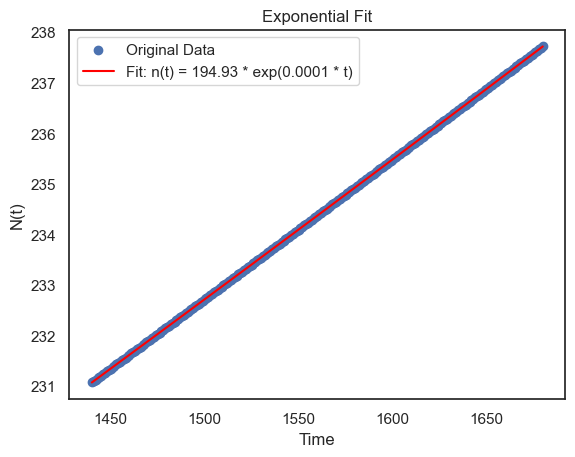

Estimated parameters: n0 = 194.93, a = 0.00011814
Fitted function: N(t) = 194.93 * exp(0.0001 * t)


In [86]:
# TESTING LONG TERM RATE VALUE

# Data Extraction
# Choose a time very far into the simulation (20+ days) in order to ensure that an equilibrium position has been reacher
start_hr = 60*24 # Make sure the start and end hour are present within the trimmed data
end_hr = 70*24
filtered_df = einar_model.resultsDf[(einar_model.resultsDf["Time"] >= start_hr) & (einar_model.resultsDf["Time"] <= end_hr)]
x_data = filtered_df["Time"].values
y_data = filtered_df["TumourSize"].values

# Fit Function Code
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy.optimize import curve_fit

def expFunc(t, n0, a):
    return n0 * np.exp(np.clip(a * t, -700, 700))

params, _ = curve_fit(expFunc, x_data, y_data, p0=[1500, 0.001])
n0_fit, a_fit = params

y_fit = expFunc(x_data, n0_fit, a_fit)

# Plotted Results Code
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, y_fit, color='red', label=f'Fit: n(t) = {n0_fit:.2f} * exp({a_fit:.4f} * t)')
plt.legend()
plt.xlabel("Time")
plt.ylabel("N(t)")
plt.title("Exponential Fit")
plt.show()

# Note that (a) should be essentially equal to the minimized tumor growth rate
print(f"Estimated parameters: n0 = {n0_fit:.2f}, a = {a_fit:.8f}")
print(f"Fitted function: N(t) = {n0_fit:.2f} * exp({a_fit:.4f} * t)")